In [1]:

import datetime
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

print("import succesfull")

import succesfull


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')
df['timeStamp']= pd.to_datetime(df['timeStamp'])

In [4]:

def printStats(dataframe):
  print("Rows     :", dataframe.shape[0])
  print("Columns  :", dataframe.shape[1])
  print("\n Features \n", dataframe.columns.to_list())
  print("\n Missing Values \n", dataframe.isnull().any())
  print("\n Unique Values \n", dataframe.nunique())

In [5]:
printStats(df)

Rows     : 49205
Columns  : 4

 Features 
 ['timeStamp', 'demand', 'precip', 'temp']

 Missing Values 
 timeStamp    False
demand        True
precip        True
temp          True
dtype: bool

 Unique Values 
 timeStamp    49205
demand       40972
precip        1004
temp          7580
dtype: int64


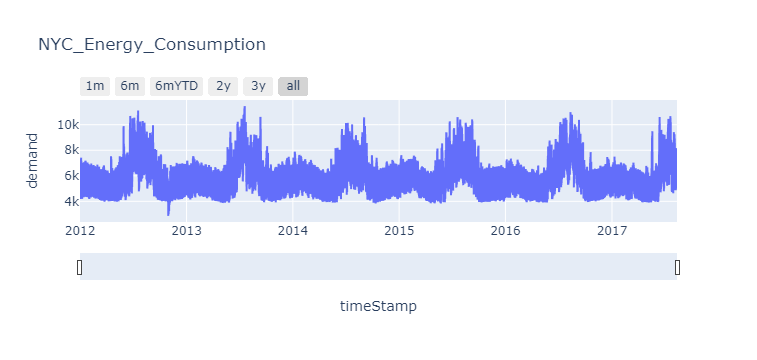

In [8]:
fig = px.line(df, x = 'timeStamp',y = 'demand',title = 'NYC_Energy_Consumption')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [9]:
ny_df =df.set_index('timeStamp')

array([<Axes: xlabel='timeStamp'>, <Axes: xlabel='timeStamp'>,
       <Axes: xlabel='timeStamp'>], dtype=object)

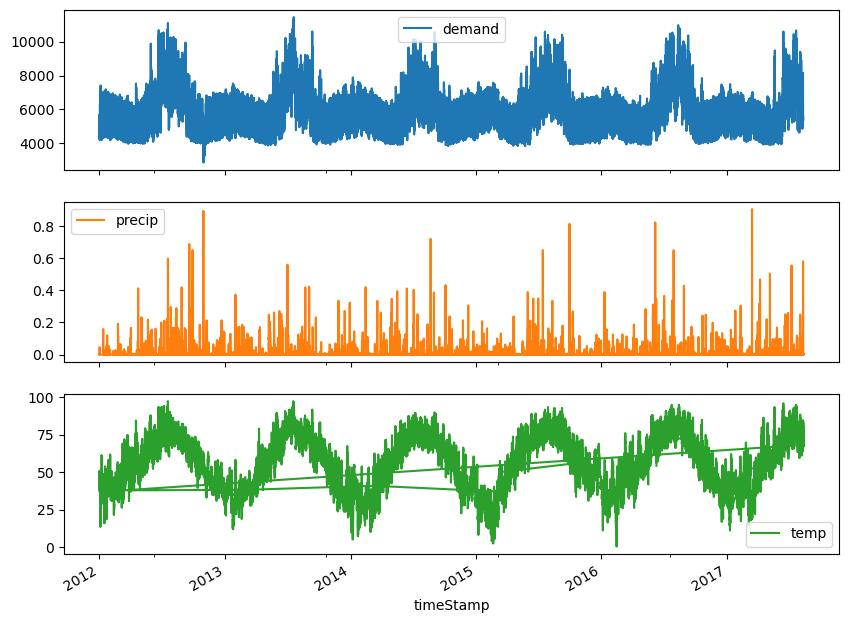

In [10]:

ny_df.plot(subplots = True)

In [11]:
ny_df_daily = ny_df.resample('D').mean()

In [12]:

ny_df_daily['demand']= ny_df_daily['demand'].fillna(method = 'ffill')
ny_df_daily['temp']= ny_df_daily['temp'].fillna(method = 'ffill')
ny_df_daily['precip']= ny_df_daily['precip'].fillna(method = 'ffill')

C:\Users\Pratyush.Thakur\AppData\Local\Temp\ipykernel_14952\1548105565.py:1: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Pratyush.Thakur\AppData\Local\Temp\ipykernel_14952\1548105565.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Pratyush.Thakur\AppData\Local\Temp\ipykernel_14952\1548105565.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [15]:
from prophet import Prophet

In [16]:
# taking temp for multivarate analysis
ny_df_final = ny_df_daily.reset_index()[['timeStamp','demand','temp']].rename({'timeStamp':'ds','demand':'y','temp':'temp'}, axis='columns')

In [17]:
ny_df_final.head(2)
     

ds            y       temp
0 2012-01-01  4954.833333  46.510000
1 2012-01-02  5302.954167  40.496667

In [18]:
#extracting month 
ny_df_final['month']= ny_df_final['ds'].dt.month

In [19]:

ny_df_final.head(2)

ds            y       temp  month
0 2012-01-01  4954.833333  46.510000      1
1 2012-01-02  5302.954167  40.496667      1

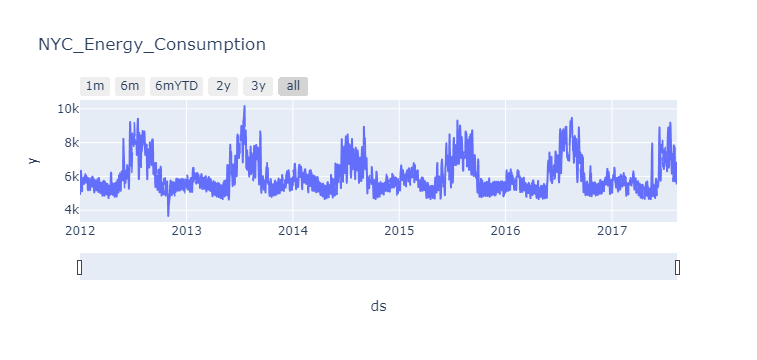

In [20]:
fig = px.line(ny_df_final, x = 'ds',y = 'y',title = 'NYC_Energy_Consumption', hover_data=['temp','month'])

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [21]:

ny_df_final[['month','temp']].groupby('month').agg({'temp':{'max','min','mean'}})

temp                      
             max        min       mean
month                                 
1      55.420455   9.507917  33.432140
2      59.360000   9.015000  34.517758
3      67.878333  20.291667  41.419884
4      72.992083  33.045833  52.600204
5      82.576250  48.090833  62.543994
6      86.916667  52.405833  71.334418
7      89.606667  66.417083  77.595627
8      87.426250  68.042083  75.525947
9      84.448750  57.274583  69.550306
10     74.277500  42.106250  58.642895
11     67.606250  27.172500  47.225638
12     64.735000  22.429583  41.520068

In [23]:
ny_df_final[['y','temp']].corr()

y      temp
y     1.000000  0.560138
temp  0.560138  1.000000

In [24]:
## there is corrlatio in between y and temp , but not that high

In [25]:

ny_df_final.query('temp>80')[['y','temp']].corr()

y      temp
y     1.000000  0.552918
temp  0.552918  1.000000

In [29]:
ny_df_final.query('temp<=80')[['y','temp']].corr()

y      temp
y     1.000000  0.469771
temp  0.469771  1.000000

In [30]:
def summer_temp(temp):
    if temp >80:
        return 1
    else:
        return 0

In [31]:
ny_df_final['summer_temp'] = ny_df_final['temp'].apply(summer_temp)

In [32]:
ny_df_final.head()
## if this is summer_temp or not

ds            y       temp  month  summer_temp
0 2012-01-01  4954.833333  46.510000      1            0
1 2012-01-02  5302.954167  40.496667      1            0
2 2012-01-03  6095.512500  26.672500      1            0
3 2012-01-04  6336.266667  20.585000      1            0
4 2012-01-05  6130.245833  33.577500      1            0

In [34]:
ny_df_final['summer_temp'].unique()

array([0, 1], dtype=int64)

In [35]:
ny_df_final['month_bins'] = pd.cut(ny_df_final['month'], bins =3, labels = False) 

In [36]:
ny_df_final['month_bins'].unique()

array([0, 1, 2], dtype=int64)

In [37]:
## making 3 bins of months 4..4 month groups

In [38]:
train = ny_df_final[(ny_df_final['ds']>='2012-01-01') & (ny_df_final['ds']<='2017-04-30')]
test = ny_df_final[(ny_df_final['ds']>'2017-04-30')]

In [39]:
train.shape

(1947, 6)

In [40]:
test.shape

(104, 6)

In [41]:
test

ds            y       temp  month  summer_temp  month_bins
1947 2017-05-01  5417.231583  60.300833      5            0           1
1948 2017-05-02  5697.950042  67.537917      5            0           1
1949 2017-05-03  5354.628500  59.413333      5            0           1
1950 2017-05-04  5235.704833  54.877083      5            0           1
1951 2017-05-05  5358.639500  55.720833      5            0           1
...         ...          ...        ...    ...          ...         ...
2046 2017-08-08  6471.626042  71.039167      8            0           1
2047 2017-08-09  6811.112167  73.852500      8            0           1
2048 2017-08-10  5582.297000  75.217500      8            0           1
2049 2017-08-11  5582.297000  72.767917      8            0           1
2050 2017-08-12  5582.297000  69.771429      8            0           1

[104 rows x 6 columns]

In [42]:
m = Prophet(interval_width = 0.95, yearly_seasonality = True)

In [43]:
## regressor is added since we think the data of temp is extracted 
## in the columns summer_temp,month_bins

In [44]:
m.add_regressor('summer_temp', standardize = False)
# if we want to standardize input then true

m.add_regressor('month_bins', standardize = False,mode = 'multiplicative' )

In [45]:

m.fit(train)

13:10:31 - cmdstanpy - INFO - Chain [1] start processing
13:10:31 - cmdstanpy - INFO - Chain [1] done processing


In [46]:

m.params

OrderedDict([('lp__', array([[5339.35]])),
             ('k', array([[0.147654]])),
             ('m', array([[0.58331]])),
             ('delta',
              array([[ 1.91260e-08, -2.21176e-03, -1.81255e-01, -4.17574e-06,
                       6.50980e-06,  1.12610e-02,  5.63615e-03,  1.38666e-02,
                       5.61964e-05,  7.04393e-06,  8.68463e-09, -5.38843e-02,
                      -3.97297e-07,  1.58150e-08,  1.46194e-01,  2.21836e-07,
                      -1.05703e-08, -9.28165e-02, -4.17547e-02, -4.70734e-08,
                       1.15825e-07,  6.10257e-06,  3.33150e-02,  2.50883e-02,
                       9.87618e-08]])),
             ('sigma_obs', array([[0.0388092]])),
             ('beta',
              array([[-0.0302783 , -0.0590602 ,  0.0520879 ,  0.0402388 , -0.00950998,
                      -0.00178635, -0.00651047, -0.00243274,  0.00449439, -0.00576224,
                       0.00140067,  0.00304381, -0.00453227, -0.00370962,  0.00403946,
            

In [48]:
## prediction for future
future = m.make_future_dataframe(periods = 104)
future.tail()

ds
2046 2017-08-08
2047 2017-08-09
2048 2017-08-10
2049 2017-08-11
2050 2017-08-12

In [50]:
## to preidct future we need to have the temp for that range
future['summer_temp']=ny_df_final['summer_temp']
future['month_bins']=ny_df_final['month_bins']

In [51]:
future

ds  summer_temp  month_bins
0    2012-01-01            0           0
1    2012-01-02            0           0
2    2012-01-03            0           0
3    2012-01-04            0           0
4    2012-01-05            0           0
...         ...          ...         ...
2046 2017-08-08            0           1
2047 2017-08-09            0           1
2048 2017-08-10            0           1
2049 2017-08-11            0           1
2050 2017-08-12            0           1

[2051 rows x 3 columns]

In [52]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2046 2017-08-08  7384.607171  6548.452777  8153.048922
2047 2017-08-09  7396.666180  6683.346620  8141.940117
2048 2017-08-10  7367.902546  6616.001039  8148.803027
2049 2017-08-11  7318.650632  6508.166124  8081.064614
2050 2017-08-12  6738.105487  5999.832079  7478.781171

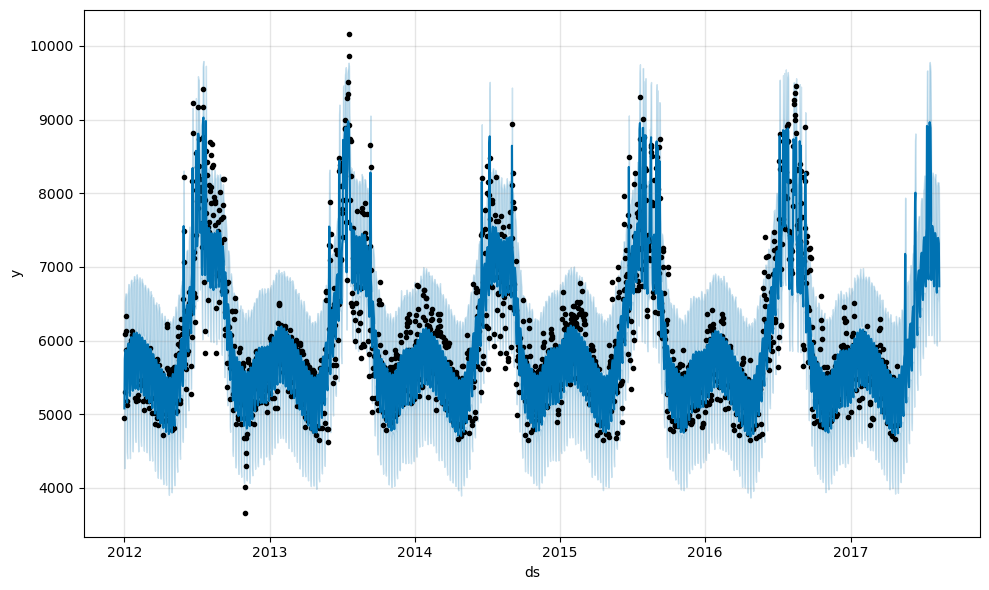

In [53]:
fig1 = m.plot(forecast)
#95% Confidence interval is the light blue color
#the black dots are actual values 
#the dark blue is the y_hat or forecasted value
     

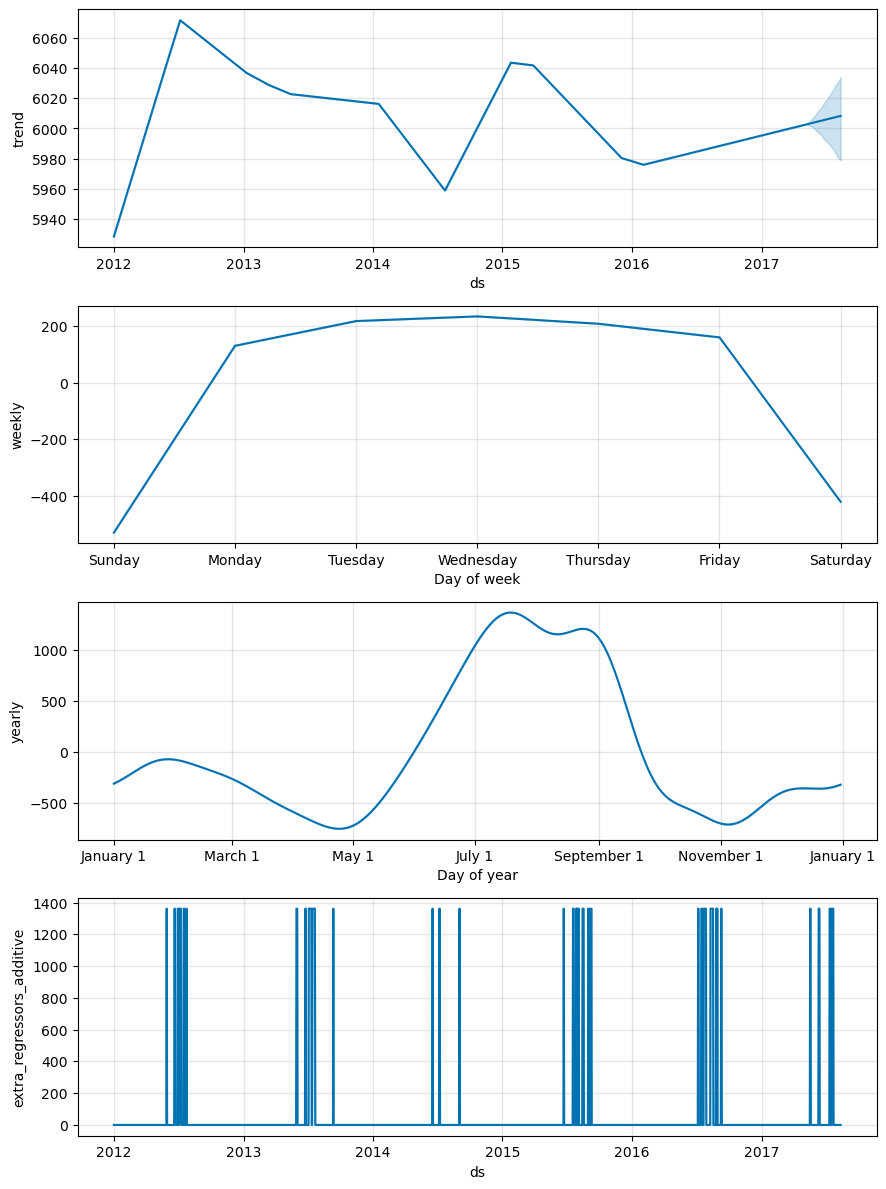

In [54]:

fig2 = m.plot_components(forecast)

In [55]:
from prophet.diagnostics import cross_validation,performance_metrics
cv_results = cross_validation(model = m,initial = '731 days',horizon='365 days')
df_p = performance_metrics(cv_results)
df_p

  0%|          | 0/5 [00:00<?, ?it/s]

13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing
13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing
13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing


horizon            mse        rmse         mae      mape  \
0    36 days 12:00:00  197128.493167  443.991546  344.478391  0.061037   
1    37 days 00:00:00  203114.933735  450.682742  351.132567  0.062158   
2    37 days 12:00:00  204334.048553  452.033238  353.367170  0.062532   
3    38 days 00:00:00  208472.627954  456.588029  357.652727  0.062982   
4    38 days 12:00:00  210648.681524  458.964793  361.445476  0.063579   
..                ...            ...         ...         ...       ...   
653 363 days 00:00:00  138358.267176  371.965411  303.902976  0.055457   
654 363 days 12:00:00  138846.084566  372.620564  303.639714  0.055411   
655 364 days 00:00:00  141196.000249  375.760562  305.487310  0.055951   
656 364 days 12:00:00  140799.316636  375.232350  304.854583  0.055853   
657 365 days 00:00:00  134788.724474  367.135839  300.189411  0.055408   

        mdape     smape  coverage  
0    0.051396  0.060926  0.906593  
1    0.051675  0.062011  0.901099  
2    0.052152  0.062402  0.901099  
3    0.053431  0.062864  0.895604  
4    0.054434  0.063480  0.895604  
..        ...       ...       ...  
653  0.051701  0.055635  0.978022  
654  0.051701  0.055636  0.978022  
655  0.052629  0.056212  0.972527  
656  0.051701  0.056150  0.972527  
657  0.051701  0.055631  0.978022  

[658 rows x 8 columns]

C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



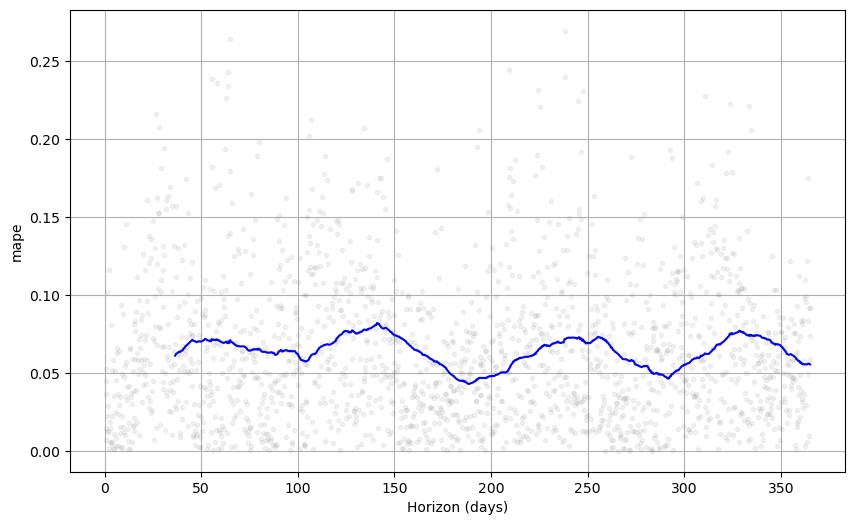

In [56]:
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results,metric='mape')

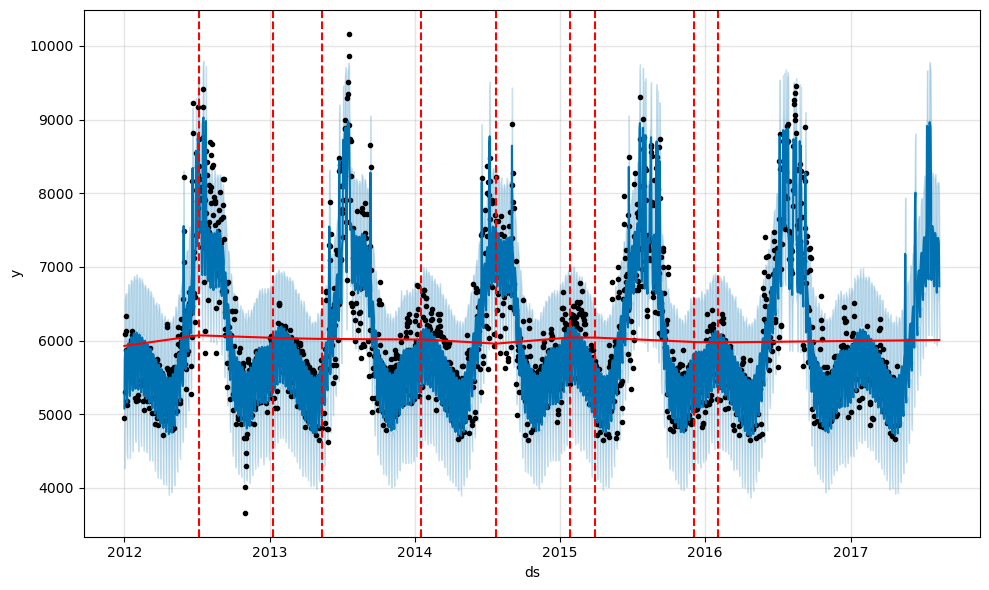

In [58]:

from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)

In [59]:

deltas = m.params['delta'][0]
deltas

array([ 1.91260e-08, -2.21176e-03, -1.81255e-01, -4.17574e-06,
        6.50980e-06,  1.12610e-02,  5.63615e-03,  1.38666e-02,
        5.61964e-05,  7.04393e-06,  8.68463e-09, -5.38843e-02,
       -3.97297e-07,  1.58150e-08,  1.46194e-01,  2.21836e-07,
       -1.05703e-08, -9.28165e-02, -4.17547e-02, -4.70734e-08,
        1.15825e-07,  6.10257e-06,  3.33150e-02,  2.50883e-02,
        9.87618e-08])

In [60]:

range(len(deltas))

range(0, 25)

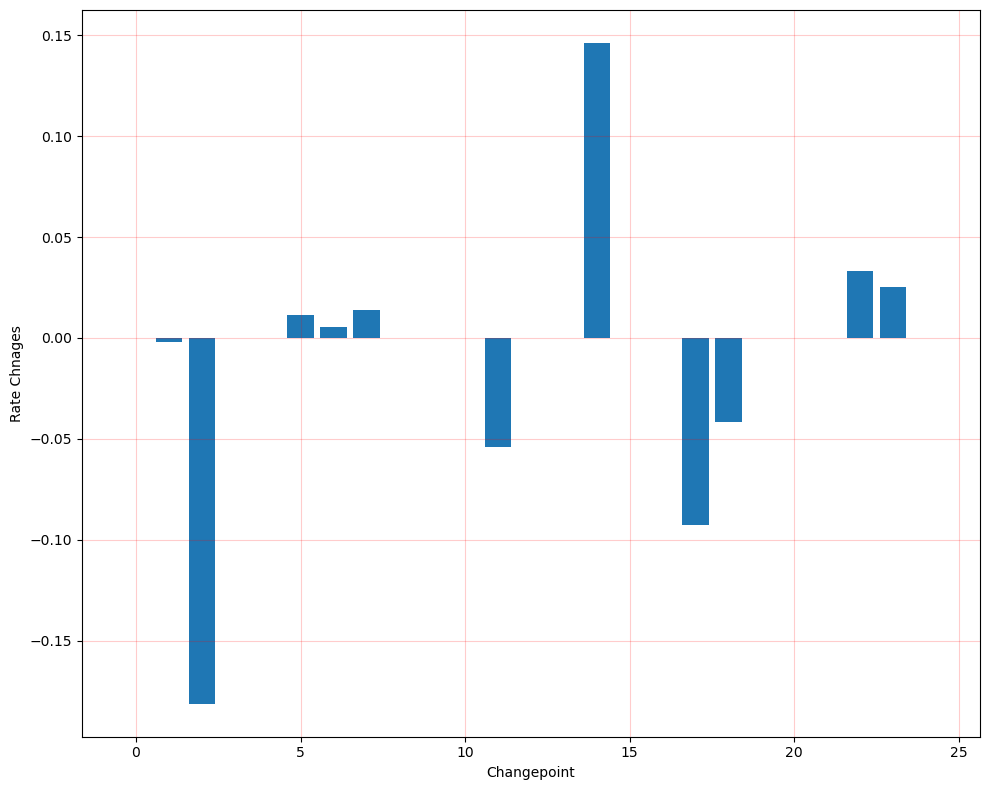

In [61]:

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)),deltas)
ax.grid(True,which='major',c='red',ls='-',alpha=0.2)
ax.set_ylabel('Rate Chnages')
ax.set_xlabel('Changepoint')
fig.tight_layout()
#Prophet plots around 25 chnage points

In [62]:
m.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]